In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data-in/'
DATA_OUT_PATH = './data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [5]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {
    'model_name' : model_name,
    'vocab_size' : prepro_configs['vocab_size'],
    'embedding_size' : 128,
    'num_filters' : 100,
    'dropout_rate' : 0.5,
    'hidden_dim' : 250,
    'output_dim' : 1
}

In [9]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size']+1,
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation='relu',
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                                      #MaxNorm(max_value=3.) 커널의 가중치값이 최대 값 3을 넘지 않게 설정
                         for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dim'],
                           activation='relu',
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dim'],
                           activation='sigmoid',
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [10]:
model = CNNClassifier(**kargs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)

In [12]:
h = model.fit(train_input, train_label, batch_size =BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[early_stopping])


Epoch 1/10
264/264 [==============================] - 14s 48ms/step - loss: 0.4611 - accuracy: 0.7749 - val_loss: 0.3896 - val_accuracy: 0.8227
Epoch 2/10
264/264 [==============================] - 12s 46ms/step - loss: 0.3541 - accuracy: 0.8446 - val_loss: 0.3807 - val_accuracy: 0.8277
Epoch 3/10
264/264 [==============================] - 12s 46ms/step - loss: 0.3023 - accuracy: 0.8720 - val_loss: 0.3944 - val_accuracy: 0.8280
Epoch 4/10
264/264 [==============================] - 32s 123ms/step - loss: 0.2569 - accuracy: 0.8930 - val_loss: 0.4146 - val_accuracy: 0.8274
Epoch 5/10
264/264 [==============================] - 12s 46ms/step - loss: 0.2223 - accuracy: 0.9092 - val_loss: 0.4334 - val_accuracy: 0.8200


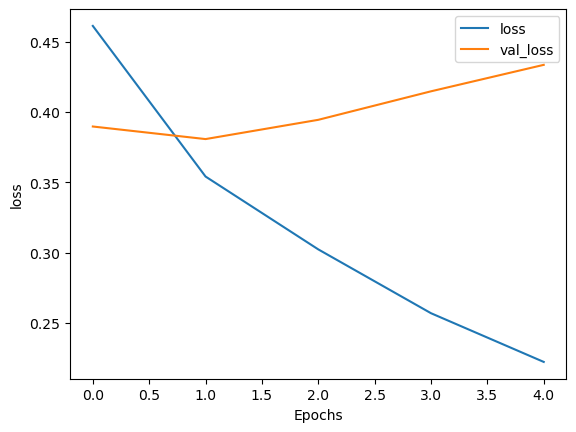

In [13]:
plot_graphs(h, 'loss')

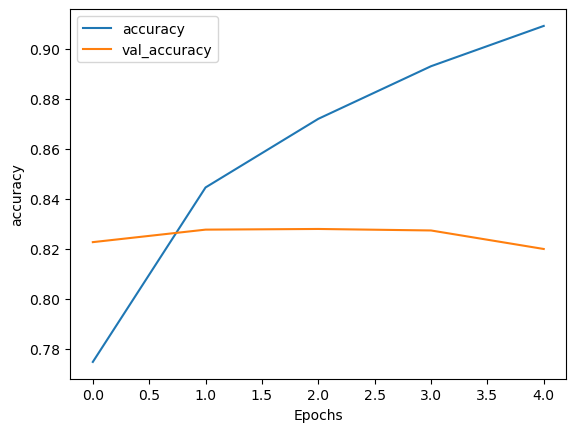

In [14]:
plot_graphs(h, 'accuracy')

In [15]:
test_input = np.load(open('data-in/nsmc_test_input.npy', 'rb'))
test_label_data = np.load(open('data-in/nsmc_test_label.npy', 'rb'))
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 2s 1ms/step - loss: 0.4365 - accuracy: 0.8182


[0.436453253030777, 0.8182200193405151]